In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 5
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c6_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c6_img20250512-11_57_42CEST.jpg"


delta_pitch_deg=5.0
delta_yaw_deg=0.0 
delta_roll_deg=0.0 
delta_r=0.000

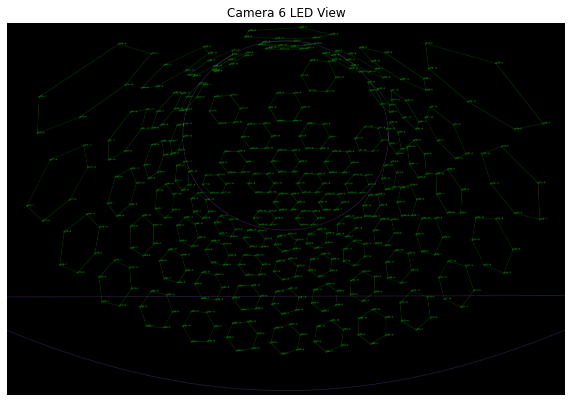

Saved image to camera6_f3253_p5_y0_r0_dr0.png


In [3]:
excluded_pmts = { 5, 9, 12, 14, 15, 16, 18, 19, 26, 27, 28, 29, 
                 30, 32, 35, 42, 43, 44, 45, 57,  59, 
                 60, 63, 74,  75, 77, 79}
# 9, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 30, 32, 35, 37, 38, 39, 40, 41, 45, 53, 54, 55, 56, 57, 63, 69, 
# 70, 71, 72, 73, 74, 77, 79}
#for delta_pitch_deg in [-5, 0, 5]:
#    for delta_yaw_deg in [-3, 0, 3]:
#        for delta_roll_deg in [-3, 0, 3]:
prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current, minarea=20, maxarea=1000, minthres=20, maxthres=255 )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 347
number of blobs: 334


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c6_with_blob_annotation.jpg


In [6]:
delta_pitch_deg=2.0
delta_yaw_deg=0.0 
delta_roll_deg=0.0 
delta_r=0.000
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = {
    '031-7': (2967, 2867),
    '008-7': (4850, 3314),
    '004-7': (4593, 1343)
}

# non-fit bounts
dev_allowed = 15.0
bounds = [ (delta_pitch_deg-dev_allowed, delta_pitch_deg+dev_allowed),   # delta_pitch_deg
           (delta_yaw_deg-dev_allowed, delta_yaw_deg+dev_allowed),   # delta_yaw_deg
           (delta_roll_deg-dev_allowed, delta_roll_deg+dev_allowed),   # delta_roll_deg
           (-0.02, 0.02), # delta_r in meters
           (-0.1, 0.1), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
           (-0.009, 0.009), # k2
           (-0.0008, 0.0008), # k3
           (-0.0002, 0.0002)   ]

matches, fitpars = prim.match_blobs( blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, excluded_pmts=excluded_pmts,
                            bounds = bounds, control_points=control_points,  use_lm=True)

In [7]:
fitpars

{'delta_pitch_deg': 2.8926352545762177,
 'delta_yaw_deg': 0.2666263247456086,
 'delta_roll_deg': -0.3304384837880916,
 'delta_r': -0.07077301480477696,
 'D_fit': array([ 0.15683392, -0.20609354,  0.18710675, -0.05573719]),
 'chi2': 6621173.194675233,
 'success': True}

In [8]:
len(matches)

281

In [9]:
matches

[('000-7', 4895.1504, 2651.7722),
 ('000-9', 4881.923, 2295.9294),
 ('000-10', 4643.253, 2291.2383),
 ('001-6', 5055.503, 3003.12),
 ('001-7', 5269.922, 3006.458),
 ('001-9', 5301.6045, 2689.487),
 ('001-10', 5077.4277, 2685.6902),
 ('001-11', 4956.3525, 2847.3486),
 ('002-7', 5726.8584, 2679.466),
 ('002-8', 5779.415, 2589.9248),
 ('002-9', 5779.662, 2326.3953),
 ('002-10', 5559.4395, 2314.0986),
 ('002-11', 5424.941, 2484.8616),
 ('003-6', 5389.8643, 1866.9381),
 ('003-7', 5130.8843, 1855.6107),
 ('003-8', 4991.205, 2058.0608),
 ('003-10', 5349.8545, 2269.8203),
 ('004-6', 4908.148, 1360.1908),
 ('004-7', 4627.0415, 1357.7805),
 ('004-9', 4632.383, 1810.0828),
 ('004-10', 4898.5674, 1813.1229),
 ('004-11', 5039.576, 1592.8193),
 ('006-6', 3968.947, 2296.9265),
 ('006-7', 3738.8325, 2306.0051),
 ('006-8', 3660.4788, 2491.8704),
 ('006-9', 3801.5388, 2662.3083),
 ('006-10', 4020.5767, 2655.227),
 ('006-11', 4109.0083, 2476.706),
 ('007-6', 4441.902, 2680.8723),
 ('007-7', 4216.796, 268

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 2.8926352545762177, 'delta_yaw_deg': 0.2666263247456086, 'delta_roll_deg': -0.3304384837880916, 'delta_r': -0.07077301480477696, 'D_fit': array([ 0.15683392, -0.20609354,  0.18710675, -0.05573719]), 'chi2': 6621173.194675233, 'success': True}
Overlay image saved to: c6_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {5, 9, 74, 75, 12, 77, 14, 15, 16, 79, 18, 19, 26, 27, 28, 29, 30, 32, 35, 42, 43, 44, 45, 57, 59, 60, 63}
geo_file= wcte_geometry_file.json
Sample matches labels: [('000-7', 4895.1504, 2651.7722), ('000-9', 4881.923, 2295.9294), ('000-10', 4643.253, 2291.2383), ('001-6', 5055.503, 3003.12), ('001-7', 5269.922, 3006.458), ('001-9', 5301.6045, 2689.487), ('001-10', 5077.4277, 2685.6902), ('001-11', 4956.3525, 2847.3486), ('002-7', 5726.8584, 2679.466), ('002-8', 5779.415, 2589.9248)]
Sample label_to_sim keys: ['000-6', '000-7', '000-8', '000-9', '000-10', '000-11', '001-6', '001-7', '001-8', '001-9']
Saved results to c6_img20250512-12_06_55CEST.json
